In [136]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

#print(plt.style.available)
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

#print(plt.style.available)
plt.style.use('ggplot')

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

In [128]:
def ax_style(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.plot(lims, lims, alpha=0.75, zorder=0, color='#505050', linestyle='--', dashes = [2,2])
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    #ax.set_xlim([-0.02, 1.0])
    #ax.set_ylim([-0.02, 1.05])
    ax.set_facecolor('#f7f7f7')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_position(('outward', 5))
    ax.spines['bottom'].set_position(('outward', 5))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.grid(b=True, which='major', color='white', linestyle='-', linewidth=3.0)
    #ax.grid(b=True, which='minor', color='white', linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    #ax.legend(loc='best', frameon=False)
    
    return ax

In [66]:
# Directories and parameters
data_root = os.path.normpath('/mnt/obi0/andreas/data/cfr')
pred_dir = os.path.join(data_root, 'predictions')

df_pred_files = sorted(glob.glob(os.path.join(pred_dir, '*_pred.parquet')))
df_cor_files = sorted(glob.glob(os.path.join(pred_dir, '*_cor.parquet')))

df_pred = pd.concat([pd.read_parquet(file) for file in df_pred_files]).reset_index(drop=True)
df_cor_0 = pd.concat([pd.read_parquet(file) for file in df_cor_files]).reset_index(drop=True)

In [80]:
df_gpu = pd.DataFrame({'model_name': sorted(list(df_cor.model_name.unique()))})
df_gpu[['dset', 'view', 'gpu', 'rest']] = df_gpu.model_name.str.split('_', n=3, expand=True)
df_gpu = df_gpu.drop(['dset', 'rest'], axis = 1)
# Join this with the main dataframe
df_cor = df_cor_0.merge(right=df_gpu, on='model_name', how='left')

In [90]:
df_cor.model_name.unique()

array(['global_a4c_dgx-1_global_cfr_calc',
       'global_a4c_dgx-1_rest_global_mbf',
       'global_a4c_dgx-1_stress_global_mbf',
       'global_a4c_gpu2_fc128_rest_global_mbf',
       'global_a4c_gpu2_fc128aug_rest_global_mbf',
       'global_a4c_gpu2_global_cfr_calc',
       'global_a4c_gpu2_rest_global_mbf',
       'global_a4c_gpu2_stress_global_mbf',
       'nondefect_a4c_dgx-1_rest_mbf_unaff',
       'nondefect_a4c_dgx-1_stress_mbf_unaff',
       'nondefect_a4c_dgx-1_unaffected_cfr'], dtype=object)

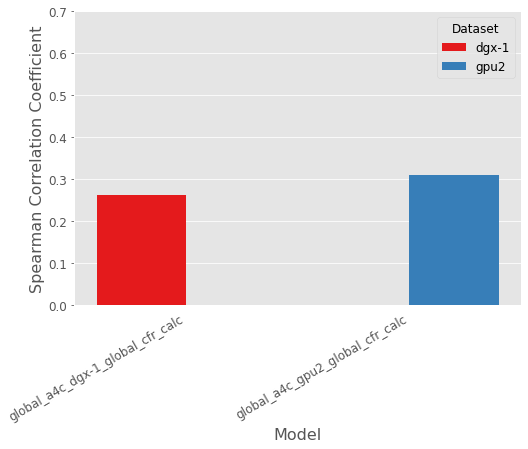

In [92]:
# Lets compare the machines
#df_cor_gpu = df_cor[(df_cor.epoch==150) & (df_cor.model_output=='rest_global_mbf')]
df_cor_gpu = df_cor[(df_cor.epoch==150) & (df_cor.model_output=='global_cfr_calc')]

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x = 'model_name', y = 'spear_cor', data=df_cor_gpu, ax=ax,
            saturation = 1, hue='gpu', palette='Set1')
ax.set(ylim=[0, 0.7], yticks=np.arange(0, 0.8, 0.1))
ax.xaxis.set_ticks_position('none') 
ax.set(xlabel = 'Model', ylabel = 'Spearman Correlation Coefficient')

leg = plt.legend(title='Dataset')
leg._legend_box.align = 'center'

fig.autofmt_xdate()

# Save plot
fig.savefig(os.path.join(pred_dir, 'cfr_models_gpu.png'), dpi=300, bbox_inches='tight')

plt.show()

In [3]:
df_corx = df_cor.loc[df_cor.groupby('model_output')['spear_cor'].idxmax()].reset_index(drop=True)
df_corx = df_corx.sort_values(by = ['dset', 'spear_cor'], ascending=False)

In [4]:
df_corx.head()

,model_name,model_output,epoch,chechkpoint_file,spear_cor,spear_p,pear_cor,pear_p,n_samples,dset
4,nondefect_a4c_dgx-1_stress_mbf_unaff,stress_mbf_unaff,100,/mnt/obi0/andreas/data/cfr/log/nondefect_a4c_d...,0.446963,1.734637e-44,0.440022,5.112244e-43,881,nondefect
2,nondefect_a4c_dgx-1_rest_mbf_unaff,rest_mbf_unaff,100,/mnt/obi0/andreas/data/cfr/log/nondefect_a4c_d...,0.343776,7.655502e-26,0.350960,6.191784e-27,881,nondefect
5,nondefect_a4c_dgx-1_unaffected_cfr,unaffected_cfr,100,/mnt/obi0/andreas/data/cfr/log/nondefect_a4c_d...,0.226273,1.083594e-11,0.263326,1.934262e-15,881,nondefect
3,global_a4c_gpu2_stress_global_mbf,stress_global_mbf,150,/mnt/obi0/andreas/data/cfr/log/global_a4c_gpu2...,0.521974,1.406801e-74,0.532282,5.110090e-78,1052,global
1,global_a4c_dgx-1_rest_global_mbf,rest_global_mbf,150,/mnt/obi0/andreas/data/cfr/log/global_a4c_dgx-...,0.444414,3.753792e-52,0.458937,6.343615e-56,1052,global


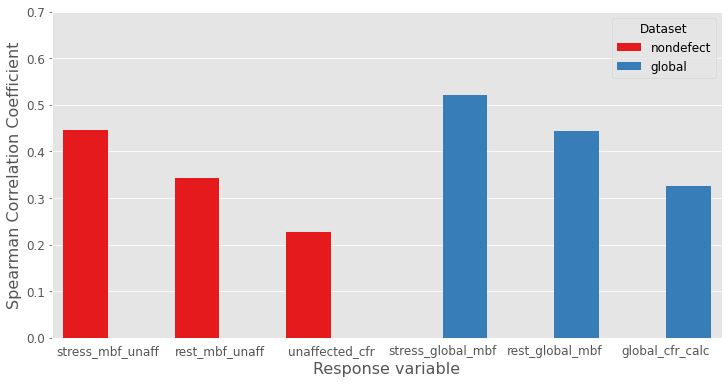

In [36]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x = 'model_output', y = 'spear_cor', data=df_corx, ax=ax,
            saturation = 1, hue='dset', palette='Set1')
ax.set(ylim=[0, 0.7], yticks=np.arange(0, 0.8, 0.1))
ax.xaxis.set_ticks_position('none') 
ax.set(xlabel = 'Response variable', ylabel = 'Spearman Correlation Coefficient')

leg = plt.legend(title='Dataset')
leg._legend_box.align = 'center'

plt.show()

# Save plot
fig.savefig(os.path.join(pred_dir, 'correlations.png'), dpi=300, bbox_inches='tight')

In [99]:
df_corx[df_corx.model_name=='global_a4c_gpu2_stress_global_mbf']

,model_name,model_output,epoch,chechkpoint_file,spear_cor,spear_p,pear_cor,pear_p,n_samples,dset
3,global_a4c_gpu2_stress_global_mbf,stress_global_mbf,150,/mnt/obi0/andreas/data/cfr/log/global_a4c_gpu2...,0.521974,1.406801e-74,0.532282,5.110090e-78,1052,global


In [103]:
df_stress_global_mbf = df_pred[(df_pred.model_name=='global_a4c_gpu2_stress_global_mbf') & (df_pred.epoch==150)]
df_stress_global_mbf.head()
X = df_stress_global_mbf.label
Y = df_stress_global_mbf.pred

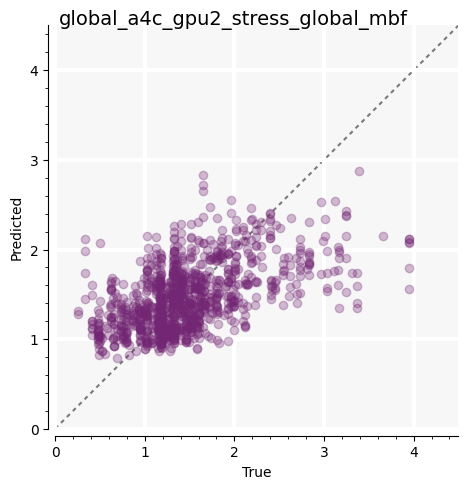

In [135]:
# Lets do a scatter plot with Rahul's style
def scatter_plot(X, Y, xlabel='X Axis Label', ylabel='Y Axis Label'):
    
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(X, Y, color='#732673', alpha = 0.3)
    ax.set(xlabel='True', ylabel='Predicted')
    ax.set(xlim=[0,4.5], ylim=[0,4.5])
    ax = ax_style(ax)
    plt.minorticks_on()
    plt.tight_layout()
    plt.rcParams.update({'font.size': 18})
    
    return fig, ax

fig, ax = scatter_plot(X, Y, xlabel='True', ylabel='Predicted')
fig.suptitle('global_a4c_gpu2_stress_global_mbf', fontsize=14)
plt.show()

#fig.savefig(os.path.join(pred_dir, 'global_a4c_gpu2_stress_global_mbf.png'), dpi=300, bbox_inches='tight')
plt.close(fig)